In [4]:
import sys
import os
from pathlib import Path

p = Path(os.path.abspath(os.getcwd()))
path = Path(p)
sys.path.insert(0, str(path.parent.absolute()) + '/sub')

from imu_processing import *
from plotting import *
import pandas as pd
import numpy as np
from machine_learning import *
from magclassification import *

cwd = str(path.parent.parent.absolute())
data_cwd = cwd + '/Data/'

labels = os.listdir(data_cwd + '/Sample')


model_path = cwd+"/Models/"
svm = load_model(model_path + "SVM20230312")

In [5]:
class AccessoryDetect:
    def __init__(self, data, model):
        self.data = data
        self.mag = self._dic_to_lst('mag')
        self.gyro = self._dic_to_lst('gyro')
        self.model = model
        self.res = []
    
    def _dic_to_lst(self, name):
        xyz = ['X', 'Y', 'Z']
        lst = []
        
        for i in xyz:
            lst.append(self.data[name + i].to_list())
        return lst        
    
    def _ts_detect(self, var_threshold = 3, dt = 0.01, ws = 5):
        def check_angle(angles, threshold):
            for angle in angles:
                if abs(angle) > threshold:
                    return False

            return True
        
        def integration_gyro(start, end, dt):
            res = []
            radian_to_angle = 57.29578

            for g in self.gyro:
                angle = 0
                for t in range(end-start):
                    delta = g[start + t] * radian_to_angle * dt
                    angle = angle + delta
                res.append(angle)
            return res
        
        total_length = len(self.gyro[0])
        is_detect = False
        stable_point = 0
        ts = []

        for t in range(total_length):
            if t + ws >= total_length-1:
                break

            angles = integration_gyro(t, t + ws, dt)

            if check_angle(angles, var_threshold):
                stable_point += 1
            else:
                stable_point = 0

            if stable_point >= ws:
                if stable_point == ws:
                    for i in range(ws-1):
                        ts.append(t + i - ws + 1)
                ts.append(t)

        return ts
    
    def _gather_ts(self, max_count = 5):
        cons_times = []
        start = -1
        end = 0
        ts = self.ts

        for t in range(1, len(ts)):
            if ts[t] == ts[t-1] + 1:
                # 연속적인 경우
                if start == -1:
                    # 이제 연속적으로 시작할 경우
                    start = ts[t-1]
                    end = start

                end += 1


            if ts[t] - ts[t-1] >= max_count:
                # 연속적이였을 경우
                if end - start >= 10 and start != -1:
                    cons_times.append([start, end])
                start = -1

        if end-start >= 10 and start != -1:
            cons_times.append([start, end])

        return cons_times
    
    
    def _stable_computation(self, split_ts, var_threshold = 1.0, max_stable_count = 5, max_ws = 10):
        def check_var(mag, t, threshold = 1.0, ws = 10):
            for i in range(3):
                if np.array(mag[i][t-ws:t]).var() > threshold:
                    return False
            return True

        STABLE = 1
        NON_STABLE = 0
        stable_count = 0
        values = [[] for _ in range(3)]
        stable_values = [[] for _ in range(3)]
        times = []

        status= STABLE
        start, end = split_ts[0], split_ts[1]
        ts_start = start

        mag_data = self.mag
        gradient_datas = get_gradient(mag_data)

        for t in range(start, end):
            if check_var(mag_data, t, threshold = var_threshold):
                stable_count += 1            
            else:
                if status == STABLE and t != start and stable_count >= max_stable_count:
                    #print('End stable point ! {}'.format(t))
                    for j in range(3):
                        stable_values[j].append(np.array(values[j]).mean()) 

                    times.append([ts_start, t])

                stable_count = 0
                status = NON_STABLE
                values = [[] for _ in range(3)]

            if stable_count >= max_stable_count:
                if stable_count == max_stable_count:
                    #print('Got stable point {}'.format(t))
                    for j in range(max_stable_count-1):
                        for k in range(3):
                            values[k].append(mag_data[k][t-max_stable_count+j+1])
                    ts_start = t - max_stable_count + 1

                status = STABLE
                for j in range(3):
                    values[j].append(mag_data[j][t])

        if status == STABLE:
            #print('End stable point !!! {}'.format(t))
            for j in range(3):
                stable_values[j].append(np.array(values[j]).mean()) 
            times.append([ts_start, end])

        return stable_values, times
    
    def _computation_stable_magdata(self):
        def conversion(values):
            res = [[values[0][i], values[1][i], values[2][i]] for i in range(len(values[0]))]

            return res

        diff_magdatas = []
        stable_times = []

        for ts in self.gathered_ts:
            #mag_data = dic_to_lst(data, ['magX', 'magY', 'magZ'])
            values, times = self._stable_computation(ts)
            values = conversion(values)
            print('Part time stamp')
            print(ts)
            print('Extracted Stable magnetometer Values')
            print(values)
            print('Corresponding time stamp')
            print(times)
            print('--------------------------------------')

            diff_magdatas.append(values)
            stable_times.append(times)

        return diff_magdatas, stable_times
    
    def diff_computation(self):
        def make_single_data(data):
            '''
            input : [magx data, magy data, magz data]
            '''
            keys = ['magX', 'magY', 'magZ']
            datas = {key : [] for key in keys}

            for idx, key in enumerate(keys):
                datas[key].append(data[idx])

            print(datas)

            return pd.DataFrame(datas)
        
        def check_angle(start, end, threshold = 0.1):
            g_gyro = get_gradient(self.gyro)
                
            g_gyroX = g_gyro[0][start:end]
            g_gyroY = g_gyro[1][start:end]

            val = max([abs(max(data)) for data in [g_gyroX, g_gyroY]])
            print('Check Angular gradient: {}'.format(val))

            if val <= threshold:
                return False
            else:
                return True
               
        def check_mag(start, end, threshold = 3.0):
            g_mag = get_gradient(self.mag)
            
            g_magX = g_mag[0][start:end]
            g_magY = g_mag[1][start:end]
            g_magZ = g_mag[2][start:end]
            val = max([abs(max(data)) for data in [g_magX, g_magY, g_magZ]])

            print('Check Max Mag acc value ({}, {}): {}'.format(start, end, val))

            if val <= threshold:
                return False
            else:
                return True

        def condition(value, time):
            if len(time) == 1:
                return

            print('------computation------')

            for i in range(len(time)):
                for j in range(i + 1, len(time)):
                    start, end = time[i][1], time[j][0]
                    t1, t2 = time[i][0], time[j][1]
                    print('{}, {} -> {}, {}'.format(t1, start, end, t2))

                    if check_mag(start, end) and check_angle(start, end + 5 if end+5 < t2 else end):
                        data = [value[j][k] - value[i][k] for k in range(3)]

                        s = [0, 0, 0]

                        for k in range(3):
                            s[k] = abs(data[k])

                        if np.array(s).mean() <= 10.0:
                            print('total < threshold')
                            continue

                        tdf = make_single_data(data)
                        print(self.model.predict(tdf))
                        self.res.append(self.model.predict(tdf)[0])
                        

        for idx in range(len(self.gathered_ts)):
            value, ts = self.stable_mag_values[idx], self.gathered_ts[idx]
            print(value)
            print(ts)
            condition(value, self.stable_times[idx])
            print('-----------------------------------------------------')
    
        
    def get_data(self):
        gyro = self._dic_to_lst('gyro')
        mag = self._dic_to_lst('mag')
        # Detect timestamp when angle is stable & gather
        self.ts = self._ts_detect()
        self.gathered_ts = self._gather_ts()
        print('Total stable angle time stamps')
        print(self.gathered_ts)
        print('-----------------------------')
        
        # Compute stable magnetometer values and ts
        self.stable_mag_values, self.stable_times = self._computation_stable_magdata()
        
        # Compute diff with condition(Angle, Mag gradients)
        self.diff_computation()
    
        return self.res

In [27]:
path = data_cwd + 'Test_nature3/'
imu_data = IMU(path)
f = imu_data[26]
print(f.path)
data = f.data


ad = AccessoryDetect(data, svm)

C:\Users\jaemi\lab_magacc/Data/Test_nature3//chargerBlack/Imu 2023-03-30 17-16-50


In [30]:
def accuarcy(imu_data, model, labels):
    acc = {label : [0, 0] for label in labels}
    ls = {label : [] for label in labels}
    
    for idx, datas in enumerate(imu_data):
        print(idx)
        ad = AccessoryDetect(datas.data, svm)
        res = ad.get_data()
        
        if datas.label in res:
            acc[datas.label][0] += 1
        else:
            acc[datas.label][1] += 1
            ls[datas.label].append(res)
    return acc, ls
  
#acc, ls = accuarcy(imu_data, svm, labels)
# print(ls)
# print(acc)
# data_result = ad.get_data()
# print(data_result)

{'bandgripBlack': [[], [], [], [], []], 'bandgripBlue': [[], [], [], [], []], 'batterypack': [[], [], [], [], []], 'blackcowlabsGriptokBlack': [[], [], [], [], []], 'casetifyWalletBlack': [[], [], [], [], ['griptokBlue']], 'chargerBlack': [[], [], [], ['bandgripBlack'], []], 'gallapleWalletWhite': [[], [], [], [], []], 'griptokBlue': [[], [], [], [], ['bandgripBlue']], 'iamdueChargerWhite': [[], [], [], [], []], 'mlinggoslotBlack': [[], [], [], [], []], 'supershellWalletGreen': [[], [], [], [], []], 'vicxxoChargerWhite': [[], ['bandgripBlue'], [], [], []], 'walletBrown': [[], [], [], [], []]}



{'bandgripBlack': [0, 5], 'bandgripBlue': [0, 5], 'batterypack': [0, 5], 'blackcowlabsGriptokBlack': [0, 5], 'casetifyWalletBlack': [0, 5], 'chargerBlack': [0, 5], 'gallapleWalletWhite': [0, 5], 'griptokBlue': [0, 5], 'iamdueChargerWhite': [0, 5], 'mlinggoslotBlack': [0, 5], 'supershellWalletGreen': [0, 5], 'vicxxoChargerWhite': [0, 5], 'walletBrown': [0, 5]}
convert_to_cm


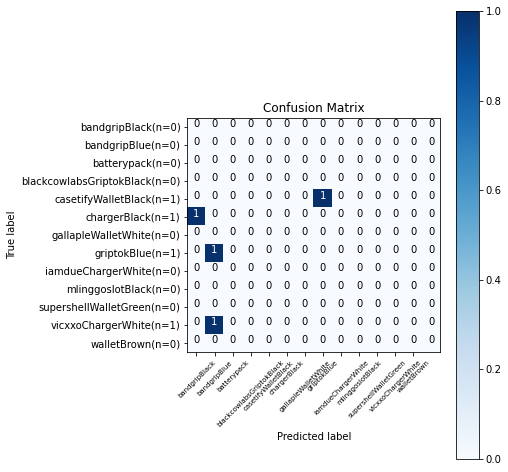

In [29]:
def convert_to_cm(dic, labels):
    l = len(labels)
    number_dic = {label : i for i, label in enumerate(labels)}
    
    res = [[0 for i in range(l+1)] for _ in range(l)]
    
    idx = 0
    print('convert_to_cm')
    for key, value in dic.items():
        # value : lst
        for lst in value:
            if len(lst) == 0:
                continue
            
            res[idx][number_dic[lst[0]]] += 1
        res[idx][number_dic[key]] += (5-len(value))
        idx += 1
        
    res = np.array(res)
    #print(res)
    return res
        
print(ls)
print('\n\n')
print(acc)

cm = convert_to_cm(ls, labels)
plot_confusion_matrix(cm, labels= labels, title = "Confusion Matrix")

In [55]:
import scipy.signal as signal

def plot_graphs_with_ts(gyro, ts, title = 'title'):
    for i, j in enumerate(['X', 'Y', 'Z']):
        plot_graph(gyro[i], title = title + j, emp = ts) 

def plot_stable_mag(data, start, end, ts, title = 'title'):
    for i, j in enumerate(['X', 'Y', 'Z']):
        plot_graph(data[i][start:end], title = 'title', emp = ts)
        
def plot_diff_with_hpf(data, name, fs = 100, cutoff = 10, order = 5):
    b, a = signal.butter(order, cutoff/(fs/2), btype='highpass')
    values = imu_to_lst(data, name)
    
    g_values = get_gradient(values)
    
    for i, j in enumerate(['X', 'Y', 'Z']):
        plot_graph(values[i], title = name + j)
        filtered_data = signal.filtfilt(b, a, values[i])
        plot_graph(filtered_data, title = 'hpf' + name + j)
#         plot_graph(g_values[i], title = 'g' + name + j)
#         filtered_data = signal.filtfilt(b, a, g_values[i])
#         plot_graph(filtered_data, title = 'hpfg' + name + j)

def plot_graph_points(graph, title = "title", points = []):
    fig, ax = plt.subplots()
    plt.title(title)
    ax.plot(graph)
    for point in points:
        ax.plot(point, graph[point], marker = 'o', markersize = 5, color = 'red')
   
    plt.show()


def corr(data, fs = 100, cutoff = 10, order = 5):
    b, a = signal.butter(order, cutoff/(fs/2), btype='highpass')
    values = imu_to_lst(data, 'mag')
    threshold = 1.0
    
    points = []
    
    filtered_values = [signal.filtfilt(b, a, values[i]) for i in range(3)]
    max_point = 0
    max_t = 0
    
    for t in range(len(filtered_values[0])):
        point = filtered_values[0][t] * filtered_values[1][t]
        
        if abs(point) >= threshold:
            points.append(t)
            
        if max_point <= abs(point):
            max_point = abs(point)
            max_t = t
    print('Maximum value : {} t : {}'.format(max_point, max_t))
    
    for i, j in enumerate(['X', 'Y', 'Z']):
        plot_graph_points(values[i], title = 'mag' + j, points = points)
        plot_graph_points(filtered_values[i], title = 'hpf' + 'mag' + j, points = points)
        
    return len(points)
    

def find_point_len(imu_data):
    res = [0 for i in range(11)]
    
    for data in imu_data:
        l = corr(data)
        if l >= 10:
            res[10] += 1
        else:
            res[l] += 1
    
    plot_graph(res, title = 'lens')
    
    return res

C:\Users\jaemi\lab_magacc/Data/Test_nature1//casetifyWalletBlack/Imu 2023-03-29 14-45-33
casetifyWalletBlack
angle 0: 9.176375238002336
angle 1: 43.966520069888254
angle 2: 90.72964346758769


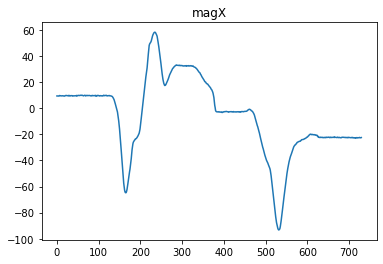

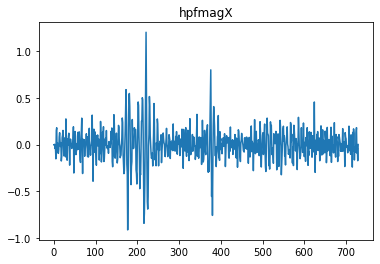

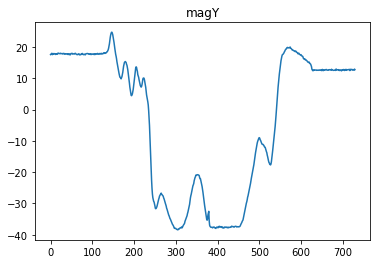

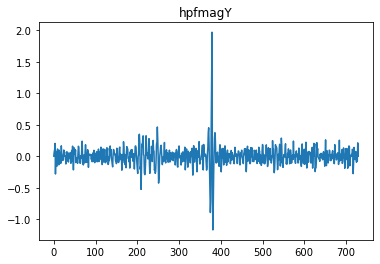

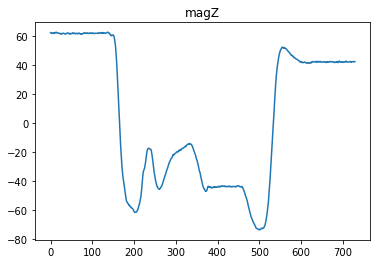

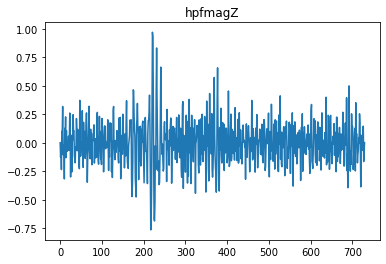

In [85]:
path = data_cwd + 'Test_nature1/'
imu_data = IMU(path)
f = imu_data[26]
print(f.path)
data = f.data
label = f.label

print(label)

values, angle = gyro_angle(data)

#corr(data)

plot_diff_with_hpf(data, 'mag')
#plot_diff_with_hpf(data, 'gyro', cutoff = 20)
# for i in angle:
#     plot_graph(i)
#plot_graphs_with_ts(imu_to_lst(data, 'mag'), title = 'mag', ts = [])

C:\Users\jaemi\lab_magacc/Data/Test_nature3//bandgripBlack/Imu 2023-03-30 16-56-33


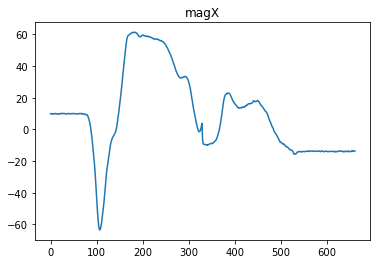

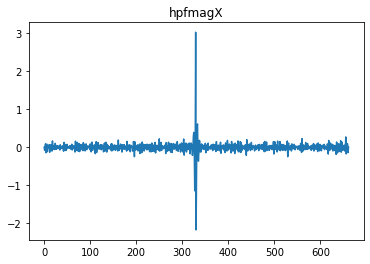

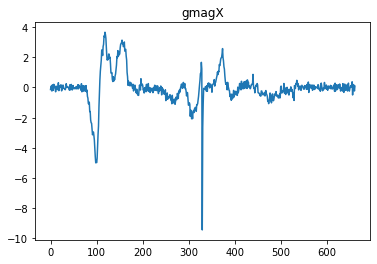

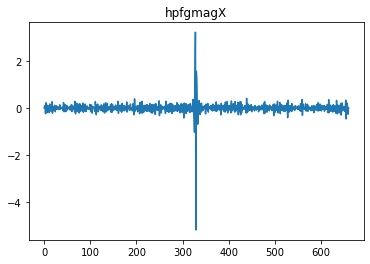

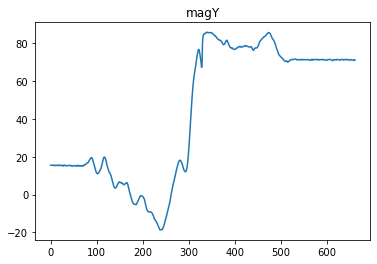

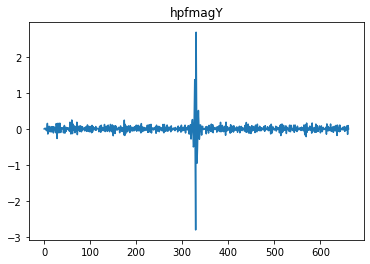

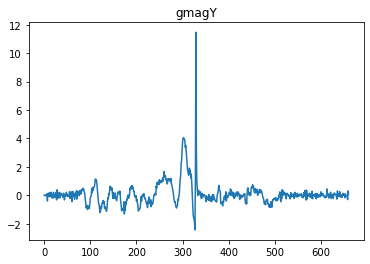

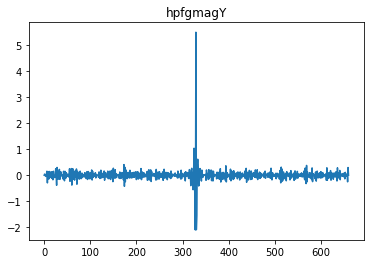

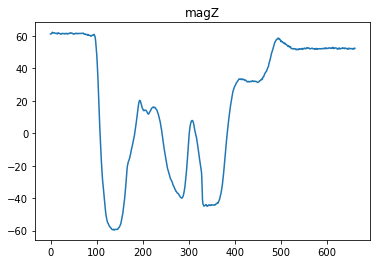

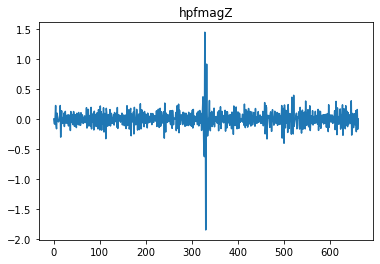

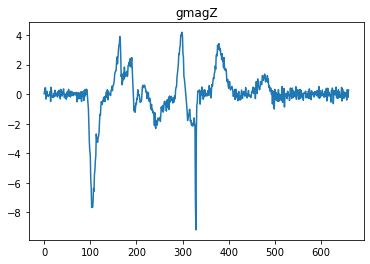

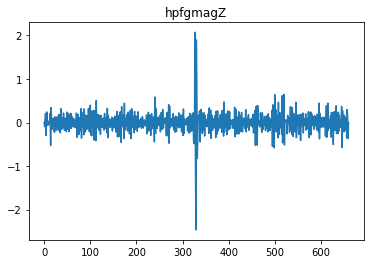

In [13]:
path = data_cwd + 'Test_nature3/'
imu_data = IMU(path)
f = imu_data[1]
print(f.path)
data = f.data

plot_diff_with_hpf(data, 'mag')

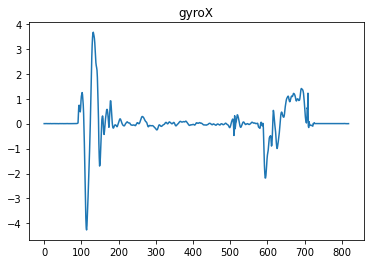

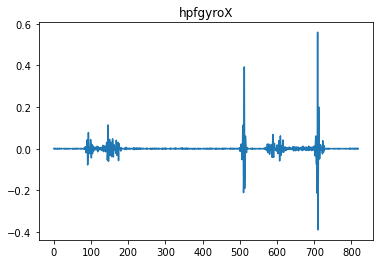

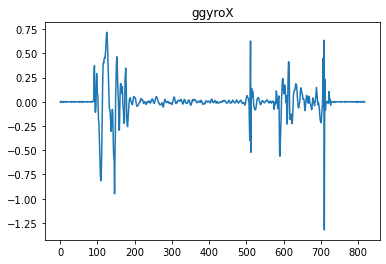

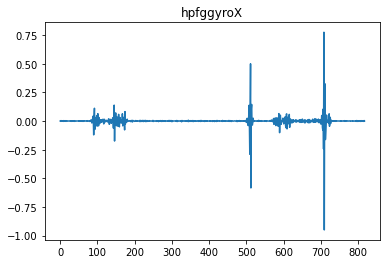

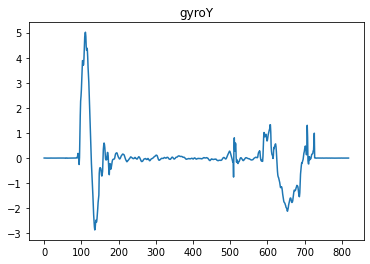

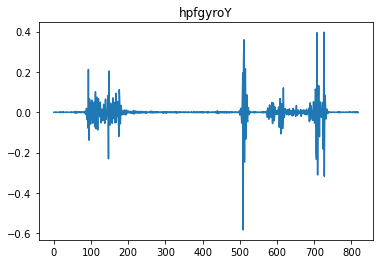

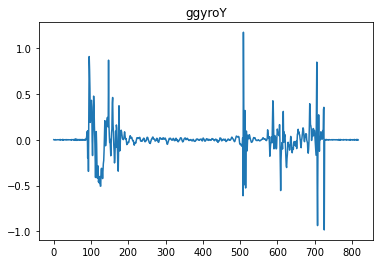

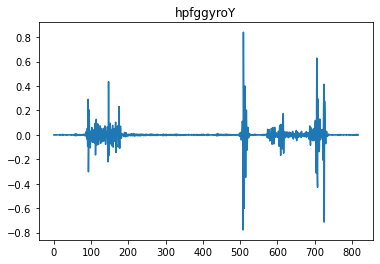

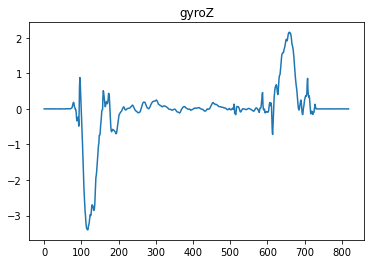

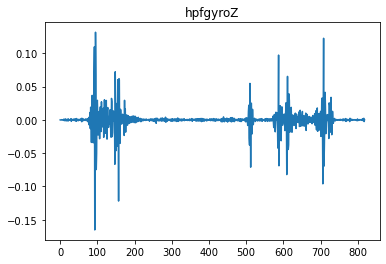

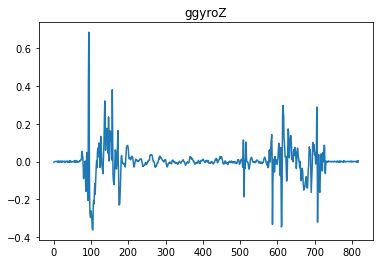

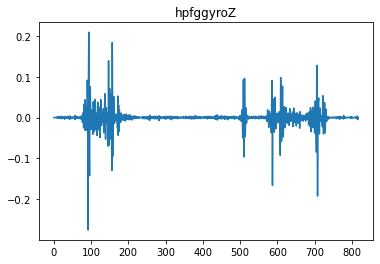

In [21]:
plot_diff_with_hpf(data, 'gyro')